# Look at debugging outputs

In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import pprint
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
import matplotlib.image as mpimg

In [2]:
class args:
    pass

args.dout = 'exp_all/model:seq2seq_nl_baseline,name:full_3_epoch_20'

In [3]:
!ls -l exp_all/model:seq2seq_nl_baseline,name:full_3_epoch_20

total 0
-rwxrwxrwx 1 root root       384 Apr 11 06:51 best_seen.json
-rwxrwxrwx 1 root root 153981994 Apr 11 06:51 best_seen.pth
-rwxrwxrwx 1 root root       384 Apr 11 06:51 best_unseen.json
-rwxrwxrwx 1 root root 153981994 Apr 11 06:51 best_unseen.pth
-rwxrwxrwx 1 root root       894 Apr 11 06:51 config.json
-rwxrwxrwx 1 root root   4845847 Apr 11 06:51 events.out.tfevents.1586456582.1f9a25fd06f3
-rwxrwxrwx 1 root root    391425 Apr 11 06:51 events.out.tfevents.1586538862.1f9a25fd06f3
-rwxrwxrwx 1 root root 153981994 Apr 11 06:51 latest.pth
-rwxrwxrwx 1 root root      2504 Apr 11 06:51 log2.txt
-rwxrwxrwx 1 root root     24124 Apr 11 06:51 log.txt
-rwxrwxrwx 1 root root    281777 Apr 11 06:51 valid_seen.debug_epoch_0.preds.json
-rwxrwxrwx 1 root root    190935 Apr 11 06:51 valid_seen.debug_epoch_14.preds.json
-rwxrwxrwx 1 root root    184246 Apr 11 06:51 valid_seen.debug_epoch_15.preds.json
-rwxrwxrwx 1 root root    190674 Apr 11 06:51 valid_seen.debug_epoch_16.preds.json
-rwxrwxrwx 

In [4]:
valid_seen_epoch_list = [0,1,3,8,14,15,16]
valid_unseen_epoch_list = [0,1,3,8,16]

# Examine Outputs across Epochs

- across epochs
- random selection
- rank by CE, BLEU

### SECTION 1: Select a random set of tasks to look at

#### Real Data

In [5]:
np.random.seed(42)

path = os.path.join(args.dout, 'valid_seen.debug_epoch_0.preds.json')
with open(path, 'r') as f:
    debug_valid_seen = json.load(f)
chosen_valid_seen_task_ids = np.random.choice(list(debug_valid_seen.keys()), size=10, replace=False)

path = os.path.join(args.dout, 'valid_unseen.debug_epoch_0.preds.json')
with open(path, 'r') as f:
    debug_valid_unseen = json.load(f)
chosen_valid_unseen_task_ids = np.random.choice(list(debug_valid_unseen.keys()), size=10, replace=False)

def find_num_high_level_goals(chosen_task_ids, debug_dat):
    '''number of high level goals (complexity) of these chosen tasks'''
    for t in chosen_task_ids:
        print (t, '\t\t\t', len(debug_dat[t]['action_high']))
    
print("\nRandomly Selected for Valid Seen: (task, number of planner subgoals)")
find_num_high_level_goals(chosen_valid_seen_task_ids, debug_valid_seen)
print("\nRandomly Selected for Valid Unseen: (task, number of planner subgoals)")
find_num_high_level_goals(chosen_valid_unseen_task_ids, debug_valid_unseen)


Randomly Selected for Valid Seen: (task, number of planner subgoals)
trial_T20190909_150916_682139_0 			 5
trial_T20190908_192636_561572_0 			 8
trial_T20190907_013001_399963_0 			 12
trial_T20190907_074712_870488_0 			 8
trial_T20190908_102840_789300_0 			 9
trial_T20190909_031040_889814_0 			 5
trial_T20190908_140701_251653_0 			 7
trial_T20190909_055649_717880_0 			 9
trial_T20190907_151802_277016_0 			 13
trial_T20190909_032318_169393_0 			 5

Randomly Selected for Valid Unseen: (task, number of planner subgoals)
trial_T20190909_123918_983775_0 			 13
trial_T20190909_123732_489327_0 			 11
trial_T20190906_191445_723170_0 			 5
trial_T20190907_020329_050110_0 			 7
trial_T20190907_170955_824797_0 			 5
trial_T20190909_210238_431966_0 			 5
trial_T20190906_224843_443882_0 			 13
trial_T20190906_214631_761426_0 			 5
trial_T20190907_074524_006355_0 			 5
trial_T20190908_114656_768805_0 			 7


In [6]:
chosen_valid_seen_task_ids = [
'trial_T20190909_150916_682139_0', 
'trial_T20190908_192636_561572_0', 
'trial_T20190907_013001_399963_0', 
'trial_T20190907_074712_870488_0', 
'trial_T20190908_102840_789300_0', 
'trial_T20190909_031040_889814_0', 
'trial_T20190908_140701_251653_0', 
'trial_T20190909_055649_717880_0', 
'trial_T20190907_151802_277016_0', 
'trial_T20190909_032318_169393_0'
]

chosen_valid_unseen_task_ids = [
'trial_T20190909_123918_983775_0',
'trial_T20190909_123732_489327_0',
'trial_T20190906_191445_723170_0',
'trial_T20190907_020329_050110_0',
'trial_T20190907_170955_824797_0',
'trial_T20190909_210238_431966_0',
'trial_T20190906_224843_443882_0',
'trial_T20190906_214631_761426_0',
'trial_T20190907_074524_006355_0',
'trial_T20190908_114656_768805_0'
]

In [7]:
urls = {
    'trial_T20190909_150916_682139_0' : 'https://youtu.be/FHGCyxlwp8E',
    'trial_T20190908_192636_561572_0': 'https://youtu.be/KYG5NEfVbjM', 
    'trial_T20190907_013001_399963_0' : 'https://youtu.be/ezmpJhbhCpI',
    'trial_T20190907_074712_870488_0':  'https://youtu.be/civKnURZaR0',
    'trial_T20190908_102840_789300_0': 'https://youtu.be/Dg9dzxXmxB4',
    'trial_T20190909_031040_889814_0': 'https://youtu.be/TpFjTu0nRoA',
    'trial_T20190908_140701_251653_0': 'https://youtu.be/LQpzGDzww1A',
    'trial_T20190909_055649_717880_0': 'https://youtu.be/C9gkb77sF14',
    'trial_T20190907_151802_277016_0': 'https://youtu.be/P9wm8lJwxT4',
    'trial_T20190909_032318_169393_0': 'https://youtu.be/R8fs1wdTMqI',
    'trial_T20190909_123918_983775_0': 'https://youtu.be/1Ha8RLnfsBg',
    'trial_T20190909_123732_489327_0': 'https://youtu.be/4V2hh2cw4No',
    'trial_T20190906_191445_723170_0': 'https://youtu.be/oZ2goybT4pA',
    'trial_T20190907_020329_050110_0': 'https://youtu.be/H-GQkQllSuA',
    'trial_T20190907_170955_824797_0': 'https://youtu.be/8zfLGiywP1A',
    'trial_T20190909_210238_431966_0': 'https://youtu.be/Ti1faQUCSnc',
    'trial_T20190906_224843_443882_0': 'https://youtu.be/z261C5NcQbU',
    'trial_T20190906_214631_761426_0': 'https://youtu.be/6dSWDozBRLU',
    'trial_T20190907_074524_006355_0': 'https://youtu.be/_TobcwcYR9Q',
    'trial_T20190908_114656_768805_0': 'https://youtu.be/AOYa3y_0uCU'
}

In [8]:
def get_language_annotations(root):
    lang_goals = []
    lang_instrs = []
    path = os.path.join(root, 'pp', 'ann_%d.json' % 0)
    with open(path, 'r') as f:
        ex = json.load(f)
        for i in range(3):
            lang_goals.append(ex['turk_annotations']['anns'][i]['task_desc'])
            lang_instrs.append(ex['turk_annotations']['anns'][i]['high_descs'])
        action_low = [a['discrete_action']['action'] for a in ex['plan']['low_actions']]
        action_high = [a['discrete_action']['action'] for a in ex['plan']['high_pddl']]
    return lang_goals, lang_instrs, action_high, action_low  

def get_ref_instrs(root):
    flatten_isntr = lambda instr: [word.strip() for sent in instr for word in sent]
    ref_instrs = []
    for i in range(3):
        path = os.path.join(root, 'pp', 'ann_%d.json' % i)
        if os.path.exists(path):
            with open(path, 'r') as f:
                ex = json.load(f)
                ref_instrs.append(flatten_isntr(ex['ann']['instr']))
    return ref_instrs

def examine_sampled_tasks(sampled_task_ids, epoch_list, split):
    sampled_results = defaultdict(dict)

    for epoch in epoch_list:

        path = os.path.join(args.dout, '{}.debug_epoch_{}.preds.json'.format(split, epoch))
        with open(path, 'r') as f:
            debug_dat = json.load(f)

        for task_id in sampled_task_ids:
            if epoch == 0:
                root = debug_dat[task_id]['root']  # root location
                sampled_results[task_id]['root'] = root
                
                if 'json_feat_2.1.0' in root:
                    img_dir = os.path.join(root.replace('json_feat_2.1.0', 'full_2.1.0/{}'.format(split)), 'raw_images')
                elif 'full_2.1.0' in root:
                    img_dir = os.path.join(root.replace('full_2.1.0', 'full_2.1.0/{}'.format(split)), 'raw_images')
                sampled_results[task_id]['image_paths'] = [os.path.join(img_dir, img_path) for img_path in os.listdir(img_dir)]

                # get all language and action annotations
                sampled_results[task_id]['lang_goal'], sampled_results[task_id]['lang_instr'],\
                sampled_results[task_id]['action_high'], sampled_results[task_id]['action_low'] \
                = get_language_annotations(root)

                sampled_results[task_id]['num_subgoals'] = len(sampled_results[task_id]['action_high'])

                # get referece lang for bleu score
                ref_instrs = get_ref_instrs(root)
                         
            sampled_results[task_id]['p_lang_instr_{}'.format(epoch)] = debug_dat[task_id]['p_lang_instr']
            sampled_results[task_id]['bleu_score_{}'.format(epoch)] = sentence_bleu(ref_instrs, debug_dat[task_id]['p_lang_instr'].split(' '))

    print('SPLIT: {}\n\n\n'.format(split))
    for task_id in sampled_task_ids:
        print("TASK :", task_id)
        print("ROOT:", sampled_results[task_id]['root'])
        print("Number of subgoals :", sampled_results[task_id]['num_subgoals'])
        if task_id in urls:
            print(urls[task_id])
        print ('---------------------------')
        print("Gold Input high-level action description:\n\n", sampled_results[task_id]['action_high'])
        print ('---------------------------')
        print("Gold Input low-level action description:\n\n", sampled_results[task_id]['action_low'])
        print ('---------------------------')
        print("Gold instruction descriptions:\n")
        for i in range(3):
            print('Annotation', i)
            print(sampled_results[task_id]['lang_goal'][i])
            print(sampled_results[task_id]['lang_instr'][i], '\n')
        print ('---------------------------')
        for e in epoch_list:
            print("\nEpoch {} Prediction Output:".format(e))
            print("BLEU score: {}".format(sampled_results[task_id]['bleu_score_{}'.format(e)]))
            print(sampled_results[task_id]['p_lang_instr_{}'.format(e)])
        print ('---------------------------')            
        print ('--------------------------------------------------------------------------------------\n\n\n\n\n')
    return sampled_results

In [9]:
chosen_valid_seen_samp_res = examine_sampled_tasks(sampled_task_ids = chosen_valid_seen_task_ids, epoch_list = valid_seen_epoch_list, split = 'valid_seen')

SPLIT: valid_seen



TASK : trial_T20190909_150916_682139_0
ROOT: data/json_feat_2.1.0/look_at_obj_in_light-Pillow-None-DeskLamp-302/trial_T20190909_150916_682139
Number of subgoals : 5
https://youtu.be/FHGCyxlwp8E
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'PickupObject', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'LookDown_15', 'ToggleObjectOn']

In [10]:
chosen_valid_unseen_samp_res = examine_sampled_tasks(sampled_task_ids = chosen_valid_unseen_task_ids, epoch_list = valid_unseen_epoch_list, split = 'valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190909_123918_983775_0
ROOT: data/json_feat_2.1.0/pick_heat_then_place_in_recep-PotatoSliced-None-Fridge-10/trial_T20190909_123918_983775
Number of subgoals : 13
https://youtu.be/1Ha8RLnfsBg
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'SliceObject', 'GotoLocation', 'PutObject', 'GotoLocation', 'PickupObject', 'GotoLocation', 'HeatObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


### SECTION 2: Look at overall best and worst tasks for one epoch

In [11]:
# compute bleu score for every task
# compute CE for every task

def rank_tasks(epoch, split, k=10, best=True, task_ids=None):
    
    path = os.path.join(args.dout, '{}.debug_epoch_{}.preds.json'.format(split, epoch))
    with open(path, 'r') as f:
        debug_dat = json.load(f)
        
    scores = {}
        
    for task_id in debug_dat:
        root = debug_dat[task_id]['root']

        # get referece lang for bleu score
        ref_instrs = get_ref_instrs(root)
        bleu_score = sentence_bleu(ref_instrs, debug_dat[task_id]['p_lang_instr'].split(' '))
        
        scores[task_id] = bleu_score
        
    top_k_task_ids = sorted(scores.items(), key=lambda x: x[1], reverse=best)[:k]
    pprint.pprint(top_k_task_ids)
    
    return [x[0] for x in top_k_task_ids], list(scores.values())

In [12]:
valid_seen_best_epoch = 16
print ("BEST valid_seen")
ranked_valid_seen_ids_best_10, all_valid_seen_bleu_scores = rank_tasks(epoch=valid_seen_best_epoch, split='valid_seen', k=10, best=True)
print ("WORST valid_seen")
ranked_valid_seen_ids_worst_10, _ = rank_tasks(epoch=valid_seen_best_epoch, split='valid_seen', k=10, best=False)

valid_unseen_best_epoch = 16
print ("BEST valid_unseen")
ranked_valid_unseen_ids_best_10, all_valid_unseen_bleu_scores = rank_tasks(epoch=valid_unseen_best_epoch, split='valid_unseen', k=10, best=True)
print ("WORST valid_unseen")
ranked_valid_unseen_ids_worst_10, _ = rank_tasks(epoch=valid_unseen_best_epoch, split='valid_unseen', k=10, best=False)

BEST valid_seen


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


[('trial_T20190908_232929_254246_0', 0.9450922039400623),
 ('trial_T20190909_105559_983897_0', 0.8498713824933443),
 ('trial_T20190909_010452_388275_0', 0.8386220538359157),
 ('trial_T20190909_055248_059513_0', 0.8051346100193656),
 ('trial_T20190908_070946_578973_0', 0.6808789931937671),
 ('trial_T20190909_051813_197569_0', 0.6779651080039419),
 ('trial_T20190909_113844_191747_0', 0.64803964547769),
 ('trial_T20190909_020200_054379_0', 0.6464870892027706),
 ('trial_T20190909_102940_350963_0', 0.6311391178801125),
 ('trial_T20190906_205324_559361_0', 0.6279520109939796)]
WORST valid_seen
[('trial_T20190909_111324_949106_0', 9.013778876140909e-155),
 ('trial_T20190908_050633_745514_0', 3.066555531622824e-78),
 ('trial_T20190911_101248_326533_0', 3.1640434732095806e-78),
 ('trial_T20190909_091314_636733_0', 3.181761482656771e-78),
 ('trial_T20190907_164104_229696_0', 3.422945016663255e-78),
 ('trial_T20190909_071128_012892_0', 3.5365767088922427e-78),
 ('trial_T20190908_201550_622420_0',

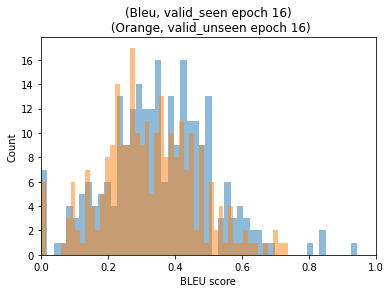

In [19]:
plt.hist(all_valid_seen_bleu_scores, density=False, bins=50, alpha=0.5)
plt.hist(all_valid_unseen_bleu_scores, density=False, bins=50, alpha=0.5)
plt.xlim(0.0, 1.0)
plt.title('(Bleu, valid_seen epoch {})\n (Orange, valid_unseen epoch {})'.format(valid_seen_best_epoch, valid_unseen_best_epoch))
plt.ylabel('Count')
plt.xlabel('BLEU score');

In [15]:
# BEST valid_seen
best_valid_seen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_seen_ids_best_10, epoch_list=valid_seen_epoch_list, split='valid_seen')

SPLIT: valid_seen



TASK : trial_T20190908_232929_254246_0
ROOT: data/json_feat_2.1.0/look_at_obj_in_light-RemoteControl-None-FloorLamp-202/trial_T20190908_232929_254246
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'LookUp_15', 'LookUp_15', 'LookUp_15', 'ToggleObjectOn']
---------------------------
Gold instruction descriptions:

Annotation 0
Examine a remote control by the light of a floor lamp.
['Turn left towards the remote control on the coffee table.', 'Pick up the remote control from the c

In [16]:
# BEST valid_unseen
best_valid_unseen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_unseen_ids_best_10, epoch_list=valid_unseen_epoch_list, split='valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190907_161210_531813_0
ROOT: data/json_feat_2.1.0/look_at_obj_in_light-BasketBall-None-DeskLamp-308/trial_T20190907_161210_531813
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'ToggleObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_

In [17]:
# WORST valid_seen
worst_valid_seen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_seen_ids_worst_10, epoch_list=valid_seen_epoch_list, split='valid_seen')

SPLIT: valid_seen



TASK : trial_T20190909_111324_949106_0
ROOT: data/json_feat_2.1.0/pick_and_place_simple-Newspaper-None-Sofa-224/trial_T20190909_111324_949106
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'MoveAhea

In [18]:
# WORST valid_unseen
worst_valid_unseen_res = examine_sampled_tasks(sampled_task_ids=ranked_valid_unseen_ids_worst_10, epoch_list=valid_unseen_epoch_list, split='valid_unseen')

SPLIT: valid_unseen



TASK : trial_T20190908_021537_611374_0
ROOT: data/json_feat_2.1.0/pick_and_place_simple-Plunger-None-Cabinet-424/trial_T20190908_021537_611374
Number of subgoals : 5
---------------------------
Gold Input high-level action description:

 ['GotoLocation', 'PickupObject', 'GotoLocation', 'PutObject', 'NoOp']
---------------------------
Gold Input low-level action description:

 ['LookDown_15', 'MoveAhead_25', 'RotateRight_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'LookDown_15', 'PickupObject', 'LookUp_15', 'RotateLeft_90', 'RotateLeft_90', 'MoveAhead_25', 'MoveAhead_25', 'MoveAhead_25', 'RotateLeft_90', 'RotateLeft_90', 'OpenObject', 'PutObject', 'CloseObject']
---------------------------
Gold instruction descriptions:

Annotation 0
Move a plunger to the cabinet
['Move to the right facing the plunger on the floor to the left of the toilet', 'Pick up the plunger on the floor', 'Move to the left facing the white cabinet door', 'Open the cab